# Imports

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

## setup scanpy options

In [2]:
sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1


# Function definitions

In [3]:
def create_barcode_map(cellBC, geneBC):
    BCmap = cellBC
    BCmap['SampleType']=""
    BCmap['BC Ratio']
    for row in BCmap.index:
        BCmap.loc[row]['SampleType'] = geneBC.loc[BCmap.loc[row]['multiseq barcode']]['Sample']
        BCmap.loc[row]['BC Ratio'] = geneBC.loc[BCmap.loc[row]['multi seq barcode']]['']
    BCmap=BCmap.set_index('cell barcode')  
    
    return BCmap

In [4]:
def read_matrix(dr):
    adata = sc.read_10x_mtx(
    dr,  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)
    
    return adata

In [5]:
def add_cell_type_to_obs(adata, BCmap):
    adata.obs_names=pd.Series(adata.obs_names).apply(lambda x: x.split('-')[0])
    cell_order=list(adata.obs_names)
    BCmap=BCmap.reindex(cell_order)
    adata.obs['SampleType']=BCmap['SampleType']
    
    return adata
    

In [6]:
def filter_minGenes_minCells(adata, min_genes, min_cells):
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)
    return adata

In [7]:
def calc_percentMito_nCounts(adata):
    mito_genes = adata.var_names.str.startswith('MT-')
    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    # add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    
    return adata



In [8]:
def keep_real_cells(adata):
    adata.obs.SampleType = adata.obs.SampleType.astype('str')
    adata = adata[adata.obs.SampleType != 'nan', :]
    return adata

In [9]:
def filter_genes_mito(adata, genes, mito):
    adata = adata[adata.obs.n_genes < genes, :]
    adata = adata[adata.obs.percent_mito < mito, :]
    
    return adata

In [10]:
def normalize_and_log(adata):
    raw = adata
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    return adata, raw

In [11]:
def regress_scale_pca(adata):
    sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    
    return adata

In [12]:
def log_ranked_genes(adata):
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    rank_genes=pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'logfoldchanges']})
    dfs = []

    for i in range((len(rank_genes.columns))//2):
        dfs.append(pd.DataFrame())

    col_n=0
    col_l=2
    for i in range(0,len(dfs)):
        dfs[i] = rank_genes[rank_genes.columns[col_n:col_l]]
        col_n+=2
        col_l+=2
    for i in range(len(dfs)):
        dfs[i] = dfs[i].fillna(0)
        dfs[i]=dfs[i].sort_values(by=dfs[i].columns[1], ascending=False)
        dfs[i].reset_index(drop=True, inplace=True)
        
    log_ranks=pd.concat(dfs, axis=1)
    
    return log_ranks

# Cell Type Mapping

In [14]:
cellBC = pd.read_csv('MDA/GBC_barcode_identities.csv', usecols=[1,2])
geneBC = pd.read_csv('MDA/genetic_barcodes.txt', sep='\t', index_col=0)

BCmap = create_barcode_map(cellBC, geneBC)

In [20]:
adata = read_matrix('./MDA')

... writing an h5ad cache file to speedup reading next time


In [ ]:
adata.obs.head()

In [16]:
adata = add_cell_type_to_obs(adata, BCmap)

Trying to set attribute `.obs` of view, making a copy.


In [17]:
adata.obs.head()

SampleType
0                          
AAACCCAAGATGTTCC        NaN
AAACCCAAGCGCTTCG        NaN
AAACCCAAGGTGAGAA        TGL
AAACCCAAGTATTAGG        NaN
AAACCCAAGTTGTCGT        NaN

# Filter

normalizing counts per cell
    finished (0:00:00)


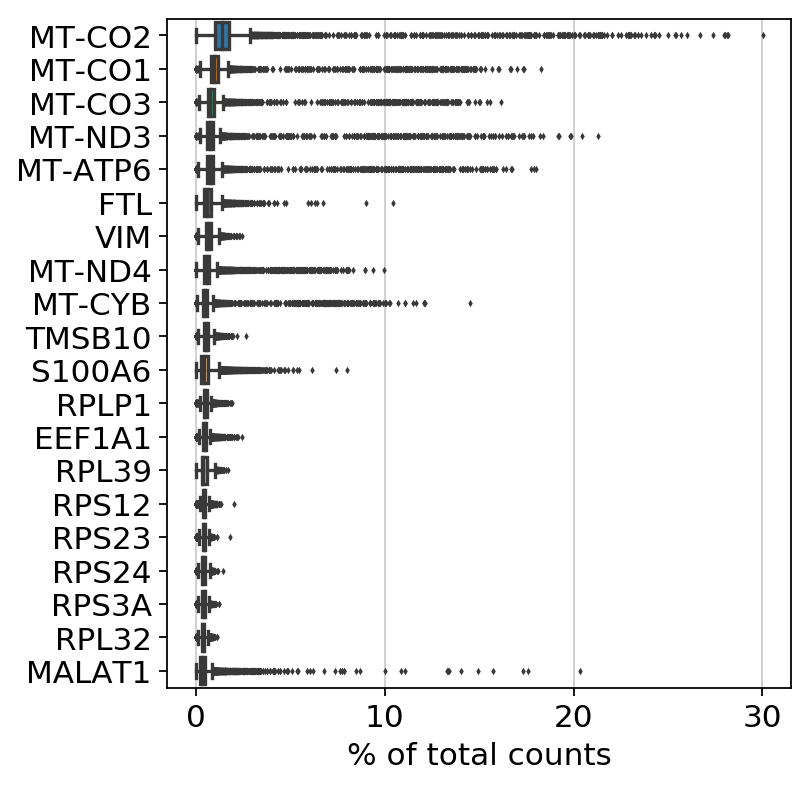

In [18]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [25]:
adata = filter_minGenes_minCells(adata, 200, 3)

filtered out 97 cells that have less than 200 genes expressed
filtered out 12074 genes that are detected in less than 3 cells


In [26]:
adata.obs.head(2)

SampleType  n_genes
0                                   
AAACCCAAGATGTTCC        NaN     4930
AAACCCAAGCGCTTCG        NaN     5697

In [27]:
adata = keep_real_cells(adata)

In [28]:
adata.obs.head(2)

SampleType  n_genes
0                                   
AAACCCAAGGTGAGAA        TGL     3986
AAACCCACACCAATTG        BoM     4704

Trying to set attribute `.obs` of view, making a copy.
... storing 'SampleType' as categorical
... storing 'feature_types' as categorical


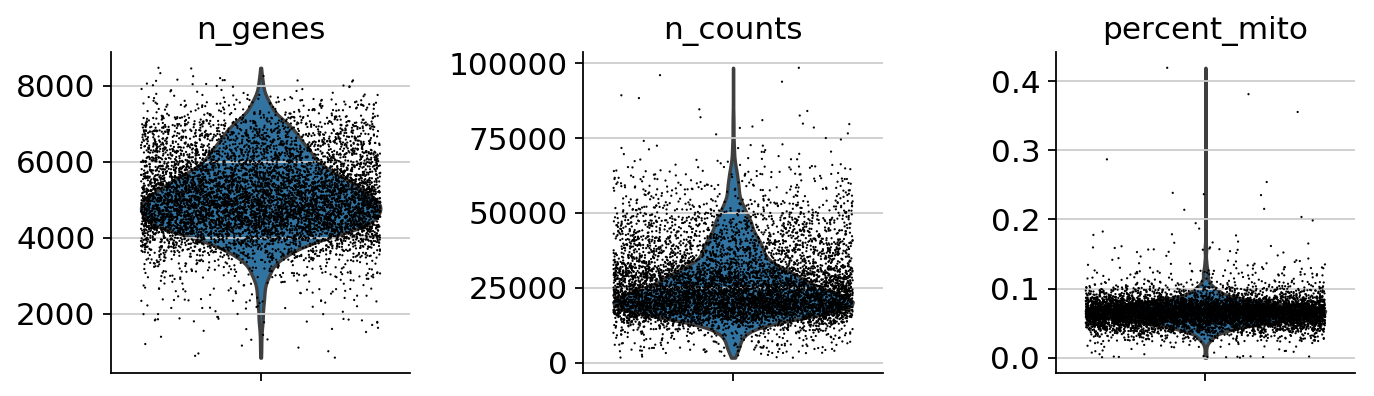

In [29]:
adata = calc_percentMito_nCounts(adata)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

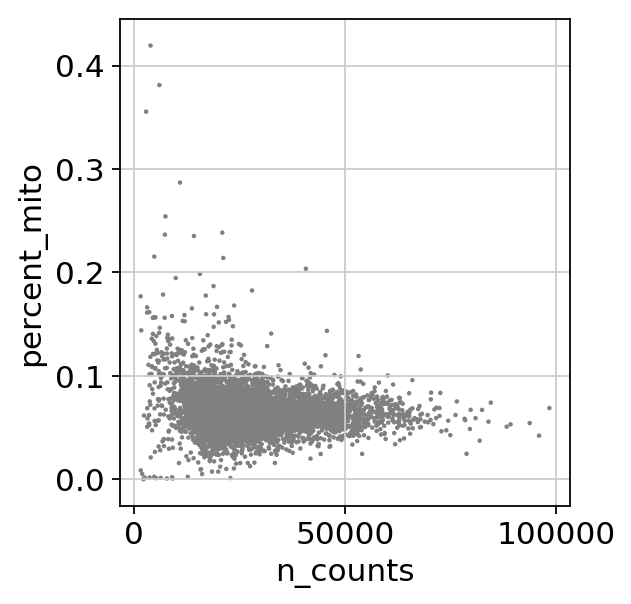

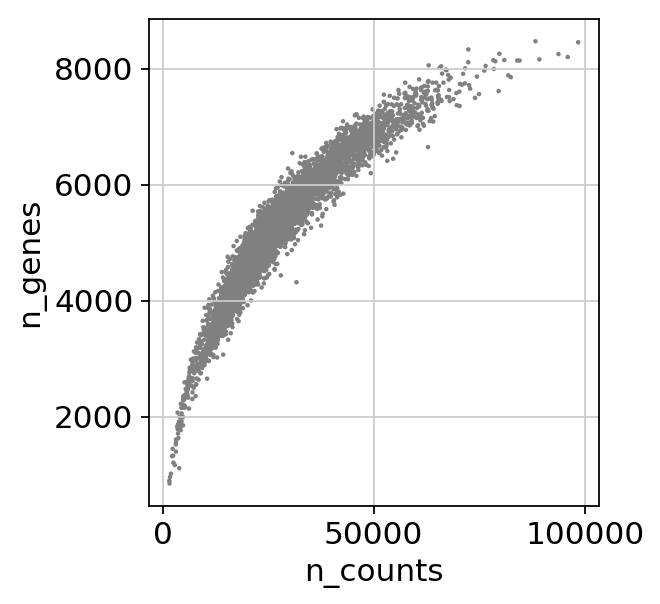

In [30]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [31]:
adata = filter_genes_mito(adata, 7500, 0.1)

In [32]:
adata, backup = normalize_and_log(adata)

normalizing counts per cell


Trying to set attribute `.X` of view, making a copy.


    finished (0:00:16)


/wynton/home/pollard/egilbertson/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


extracting highly variable genes
    finished (0:00:02)


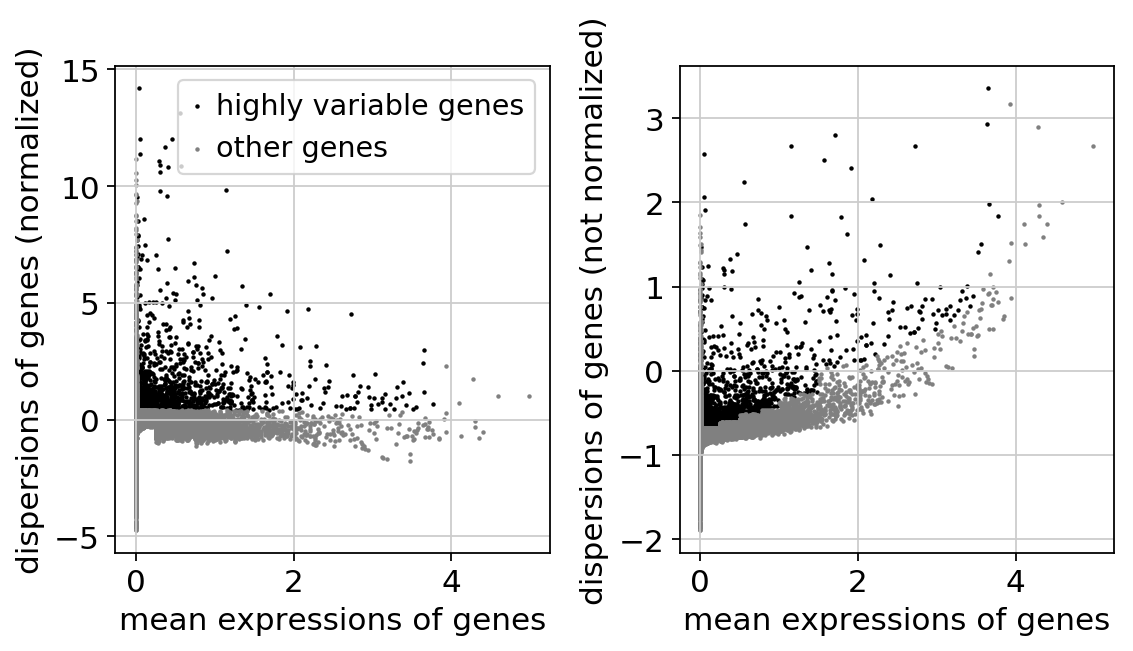

In [33]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3.8, min_disp=0.4)
sc.pl.highly_variable_genes(adata)

In [34]:
adata = adata[:, adata.var.highly_variable]

In [35]:
adata = regress_scale_pca(adata)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:17)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:02)


# Cluster

## Visualize

In [36]:
adata.var.head()

gene_ids    feature_types  n_cells  highly_variable     means  \
KLHL17  ENSG00000187961  Gene Expression     1873             True  0.041987   
HES4    ENSG00000188290  Gene Expression     6849             True  0.184543   
ISG15   ENSG00000187608  Gene Expression    13796             True  0.520304   
MXRA8   ENSG00000162576  Gene Expression     3179             True  0.092816   
VWA1    ENSG00000179403  Gene Expression      974             True  0.023838   

        dispersions  dispersions_norm  
KLHL17    -0.607443          0.712109  
HES4      -0.535968          1.015210  
ISG15     -0.288241          1.447474  
MXRA8     -0.662394          0.479084  
VWA1      -0.674504          0.427730

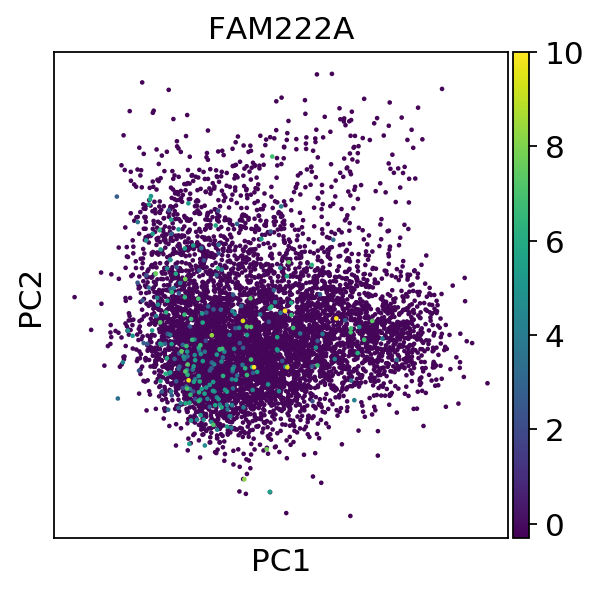

In [37]:
sc.pl.pca(adata, color='FAM222A')

Look at variance explained by PCs

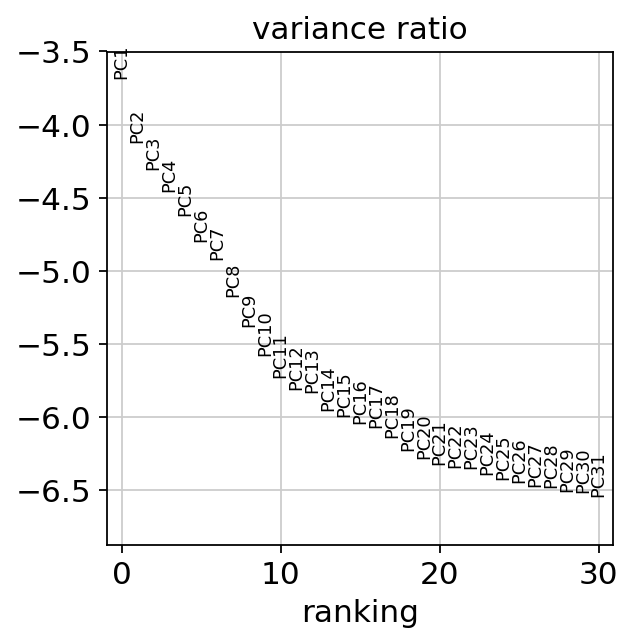

In [38]:
sc.pl.pca_variance_ratio(adata, log=True)

Check neighbors --- choose number of PCs to use

In [39]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:04)


computing UMAP
    finished (0:00:17)


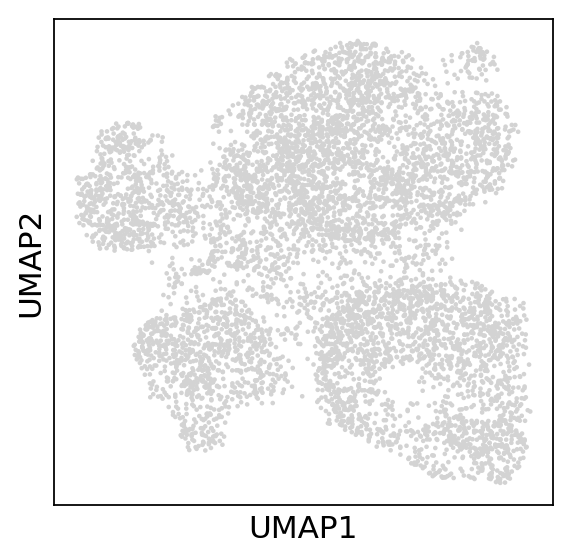

In [40]:
sc.tl.umap(adata)
sc.pl.umap(adata)

## Run Leiden Clustering

In [41]:
sc.tl.leiden(adata)

running Leiden clustering
    finished (0:00:01)


In [42]:
adata.obs.head(2)

SampleType  n_genes  percent_mito  n_counts leiden
0                                                                  
AAACCCAAGGTGAGAA        TGL     3986      0.078526   14785.0     11
AAACCCACACCAATTG        BoM     4704      0.041420   19556.0      3

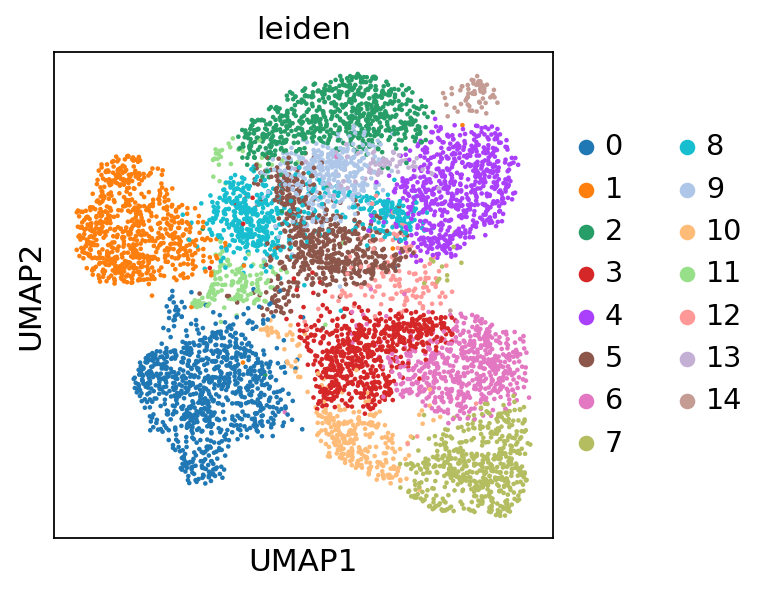

In [43]:
sc.pl.umap(adata, color=['leiden'])

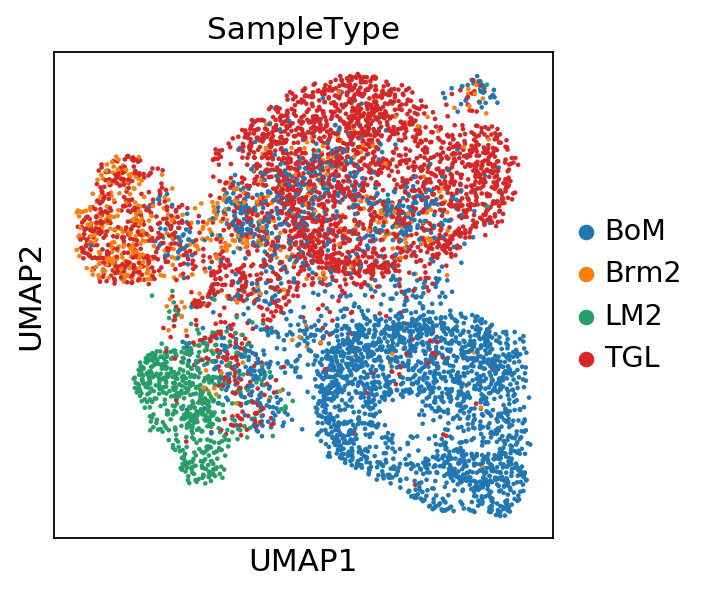

In [44]:
sc.pl.umap(adata, color=['SampleType'])

# Ranking Genes

ranking genes


/wynton/home/pollard/egilbertson/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished (0:00:02)


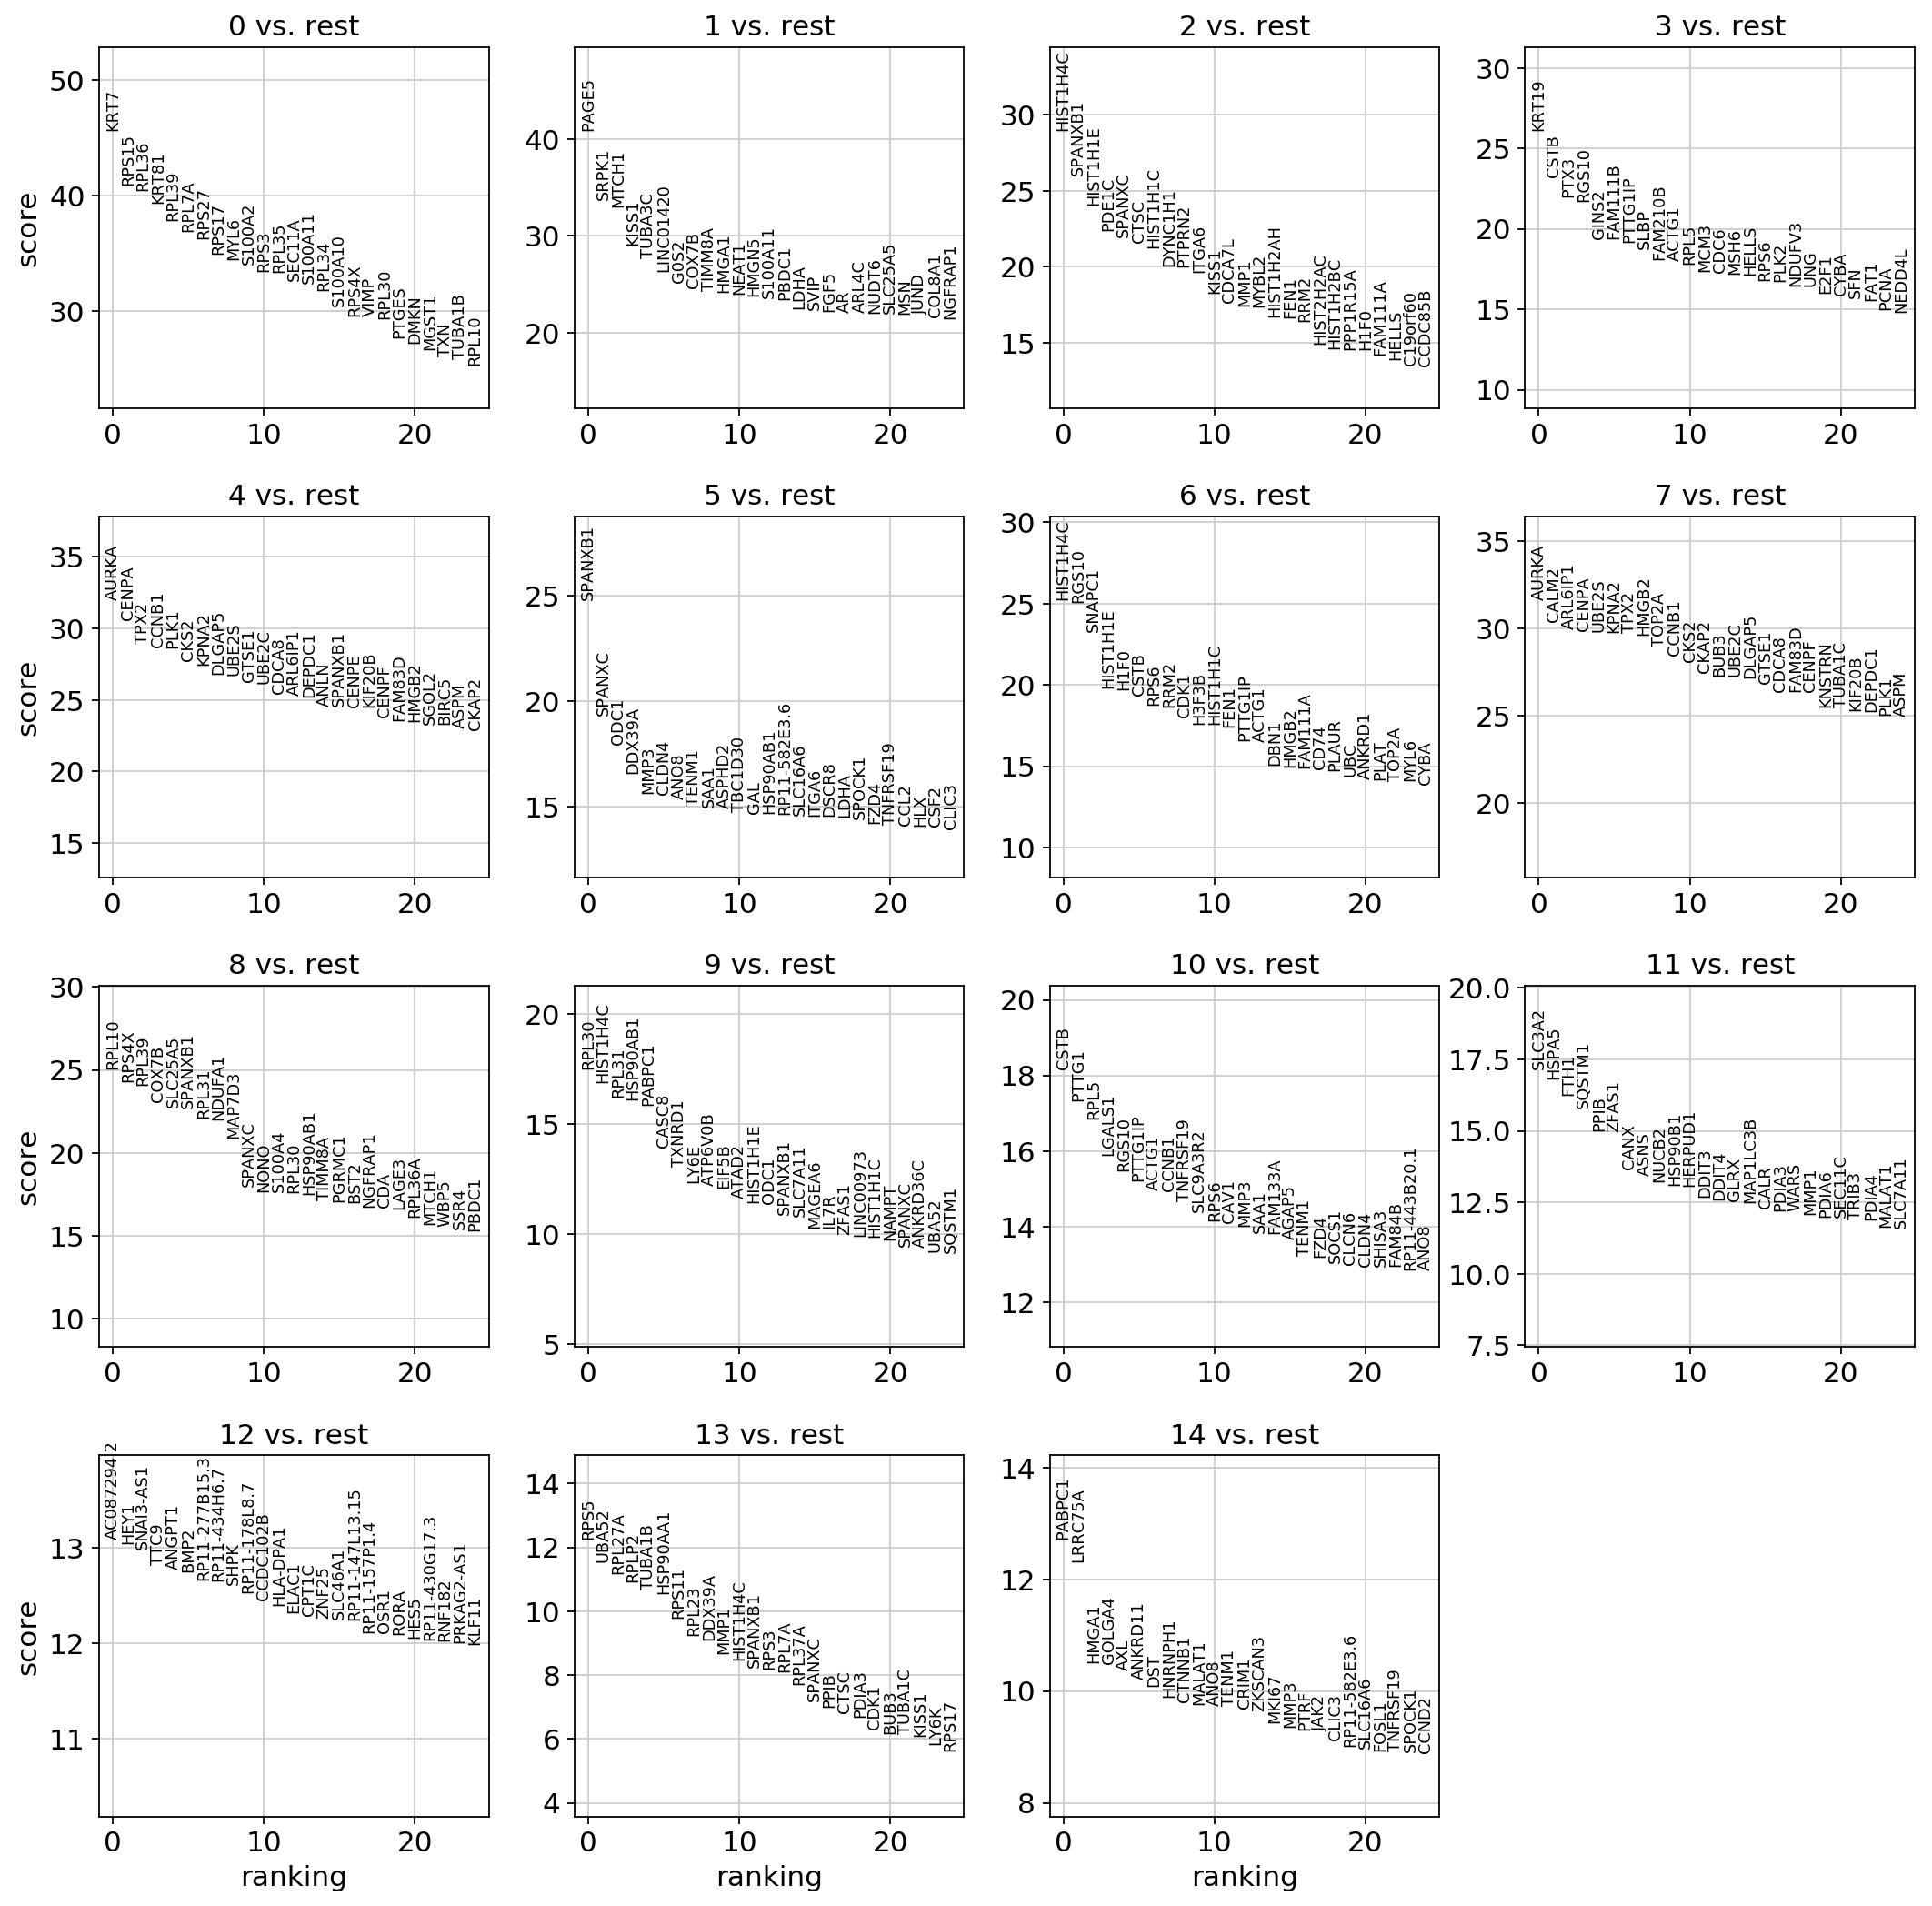

In [80]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [81]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head()

0       1         2      3      4        5         6        7        8  \
0   KRT7   PAGE5  HIST1H4C  KRT19  AURKA  SPANXB1  HIST1H4C    AURKA    RPL10   
1  RPS15   SRPK1   SPANXB1   CSTB  CENPA   SPANXC     RGS10    CALM2    RPS4X   
2  RPL36   MTCH1  HIST1H1E   PTX3   TPX2     ODC1    SNAPC1  ARL6IP1    RPL39   
3  KRT81   KISS1     PDE1C  RGS10  CCNB1   DDX39A  HIST1H1E    CENPA    COX7B   
4  RPL39  TUBA3C    SPANXC  GINS2   PLK1     MMP3      H1F0    UBE2S  SLC25A5   

          9      10      11          12      13       14  
0     RPL30    CSTB  SLC3A2  AC087294.2    RPS5   PABPC1  
1  HIST1H4C   PTTG1   HSPA5        HEY1   UBA52  LRRC75A  
2     RPL31    RPL5    FTH1   SNAI3-AS1  RPL27A    HMGA1  
3  HSP90AB1  LGALS1  SQSTM1        TTC9   RPLP2   GOLGA4  
4    PABPC1   RGS10    PPIB      ANGPT1  TUBA1B      AXL

In [82]:
logFC_ranks_leiden = log_ranked_genes(adata)

In [89]:
logFC_ranks_leiden.head()

0_n       0_l     1_n  1_l        2_n       2_l          3_n  \
0           BBS5  6.927266   PAGE5  0.0       CSF2  5.782866        KRT19   
1           AGR2  3.966360  ARMCX2  0.0       CCL2  4.831431       SMURF2   
2  RP11-567M16.6  3.100410   PLAC8  0.0  HIST1H2BN  3.695485       IFITM2   
3        ATXN7L2  3.044163   C4BPB  0.0       ATF3  2.976439         IRS1   
4         KLHL24  2.381727   RPLP2  0.0        FOS  2.345701  RP11-54H7.4   

   3_l     4_n  4_l  ...    10_n      10_l       11_n  11_l           12_n  \
0  0.0   AURKA  0.0  ...  ASPHD2  6.493516     SLC3A2   0.0        FAM222A   
1  0.0  PTPRN2  0.0  ...    DKK3  6.319841  GABARAPL1   0.0  RP11-498P14.5   
2  0.0   SGOL1  0.0  ...  SHISA3  5.413435      OTUD1   0.0  RP11-708J19.1   
3  0.0   CASC5  0.0  ...  SPOCK1  5.165066   SERPINE2   0.0  RP11-277B15.3   
4  0.0    NEK2  0.0  ...    FZD4  5.121092      SESN2   0.0        BHLHE41   

        12_l     13_n      13_l     14_n      14_l  
0  10.491769     NBEA  7.954758  CCDC190  8.334968  
1   8.369774     PLD1  7.011008     FGD1  5.806505  
2   7.576521   ZNF155  6.797936   LRSAM1  5.704111  
3   6.270446   MAGEB2  6.795584    CLIC3  2.822761  
4   6.246469  ANGPTL4  6.610587     SAA1  2.004899  

[5 rows x 30 columns]

In [90]:
sc.tl.rank_genes_groups(adata, 'SampleType', method='wilcoxon')

ranking genes


/wynton/home/pollard/egilbertson/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished (0:00:01)


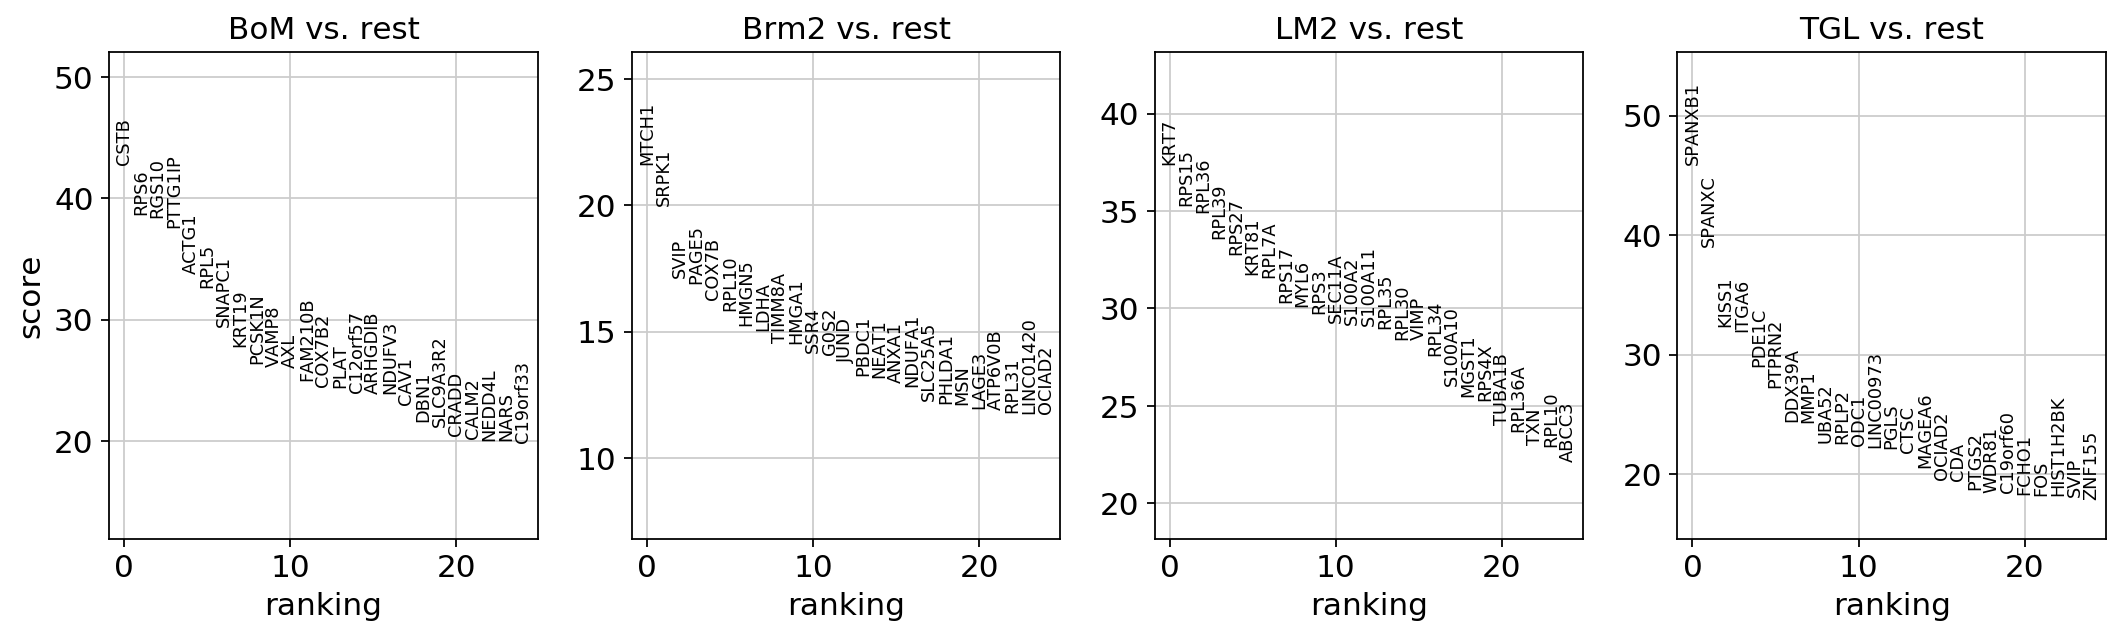

In [91]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [92]:
logFC_ranks_cell_type = log_ranked_genes(adata)

In [93]:
logFC_ranks_cell_type.head()

BoM_n  BoM_l   Brm2_n  Brm2_l          LM2_n     LM2_l         TGL_n  \
0     CSTB    0.0    MTCH1     0.0          FABP4  5.201162         CNIH3   
1    CCND1    0.0    ITGA6     0.0           CST4  5.092102          LIPH   
2  S100A10    0.0    KRT18     0.0         TMEM40  4.411688          FZD5   
3    RIMS2    0.0  SDCCAG8     0.0        ATXN7L2  3.462207       SPANXB1   
4     ECM1    0.0      NRK     0.0  RP5-1198O20.4  3.197306  RP5-1092A3.4   

      TGL_l  
0  5.741773  
1  1.430926  
2  0.474340  
3  0.000000  
4  0.000000

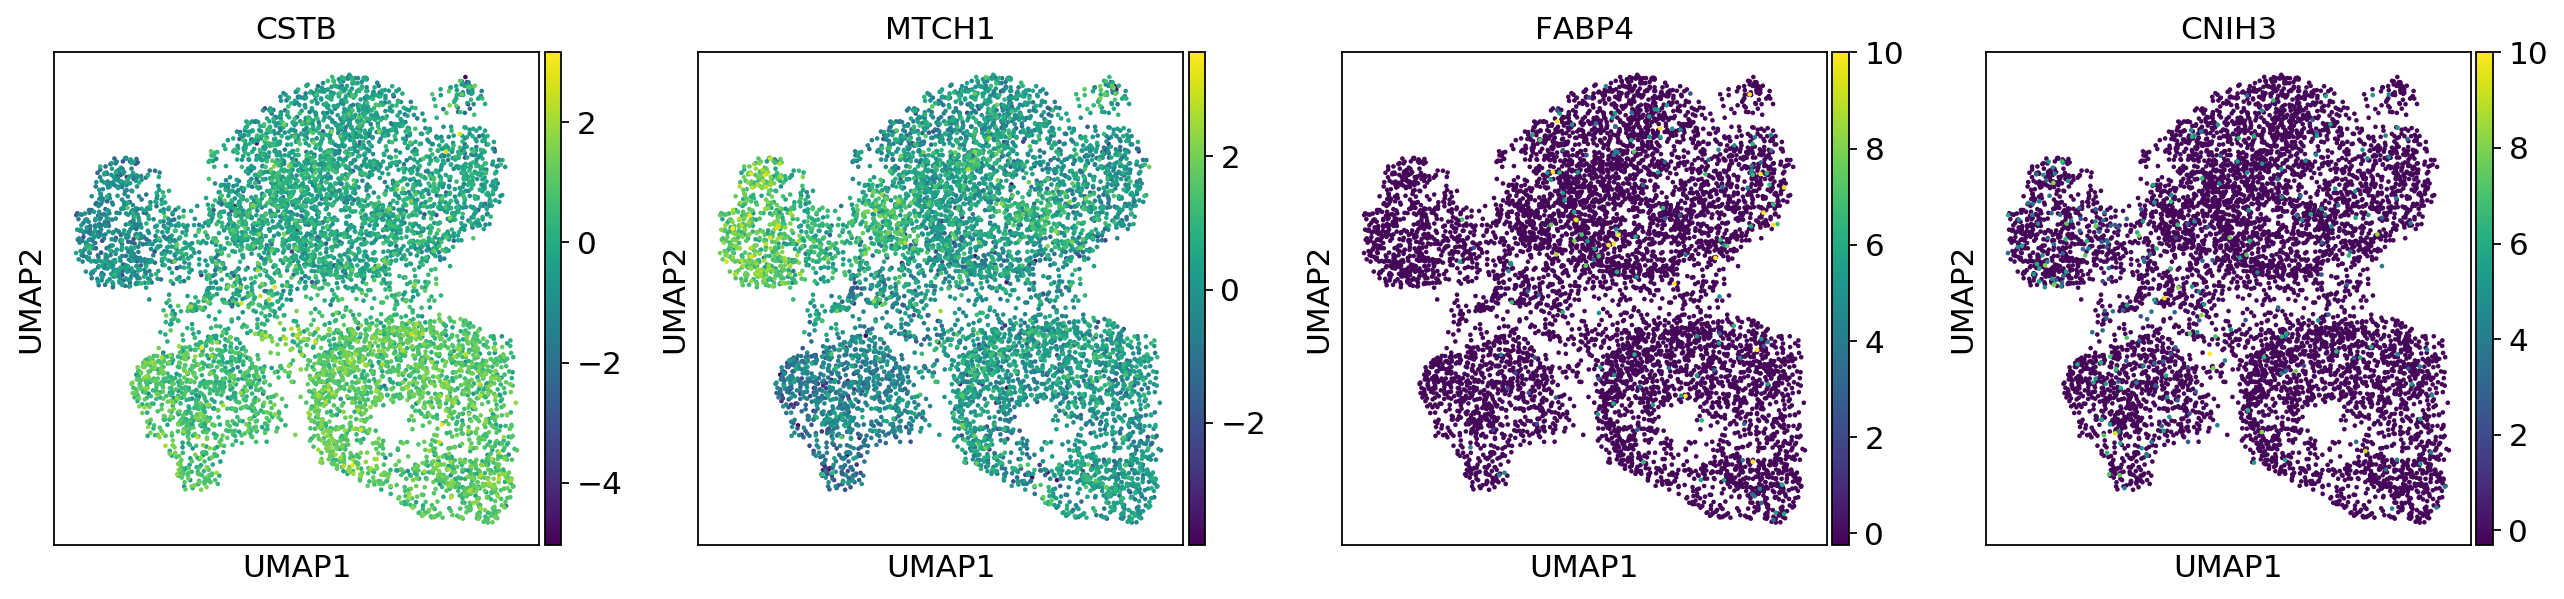

In [68]:
sc.pl.umap(adata, color=['CSTB','MTCH1','FABP4','CNIH3'])

